In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Voice Signal Vector: 
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.8941189e-05 1.7224324e-04
 1.2880834e-04]


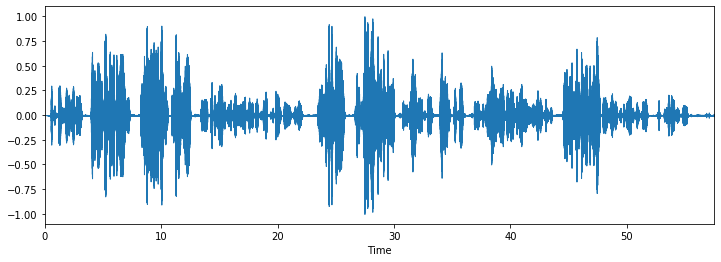

In [0]:
import numpy as np
import numpy
import scipy.io.wavfile
import os,sys
from scipy.fftpack import dct

from sklearn import mixture
from sklearn.externals import joblib
import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import librosa

import IPython.display as ipd
import librosa.display

import scipy.stats as st

original_data = '/content/gdrive/My Drive/dataset/complain/original/201801170479_20180117_105911_1966_1047.wav'

load_path ="/content/gdrive/My Drive/dataset/complain/mel"
save_path = f'{load_path.split(".")[0]}.png'

frame_length = 0.032
frame_stride = 0.010

y, sr = librosa.load(original_data, sr=16000)

print("Voice Signal Vector: \n{}".format(y))

# Voice waveform 
plt.figure(figsize=(12, 4))
librosa.display.waveplot(y, sr=sr)
plt.show()

ipd.Audio(y, rate=sr)


* 음성파일업로드

In [0]:
#sample_rate, signal = scipy.io.wavfile.read(original_data)
signal, sample_rate = librosa.load(original_data, sr=16000)
print('sample rate : {}, samples.shape : {}'.format(sample_rate, signal.shape))

i = 10
j = 40

signal = signal[int(i * sample_rate):int(j * sample_rate)]  # Keep the first i seconds

ipd.Audio(signal, rate=sample_rate)

sample rate : 16000, samples.shape : (920448,)


* 음성신호증폭

[-0.3426328  -0.42402822 -0.4446688  ...  0.04070535  0.01070587
  0.01303698]


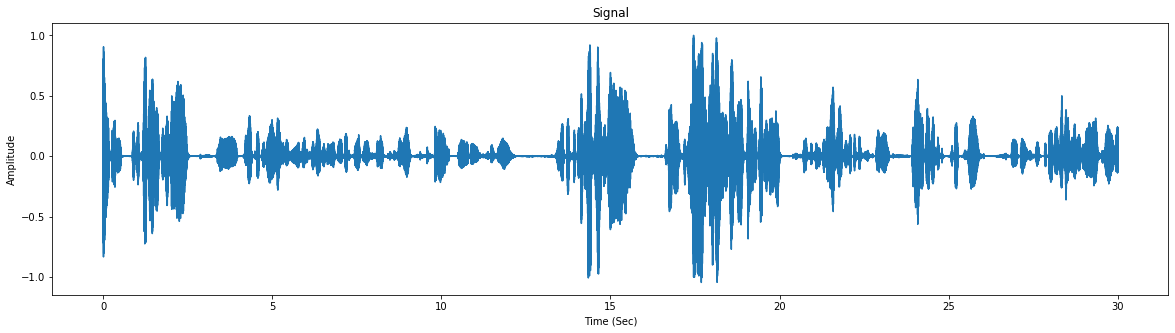

[-0.09167439 -0.03336141  0.02941811 ... -0.04395611 -0.02877833
  0.00265229]


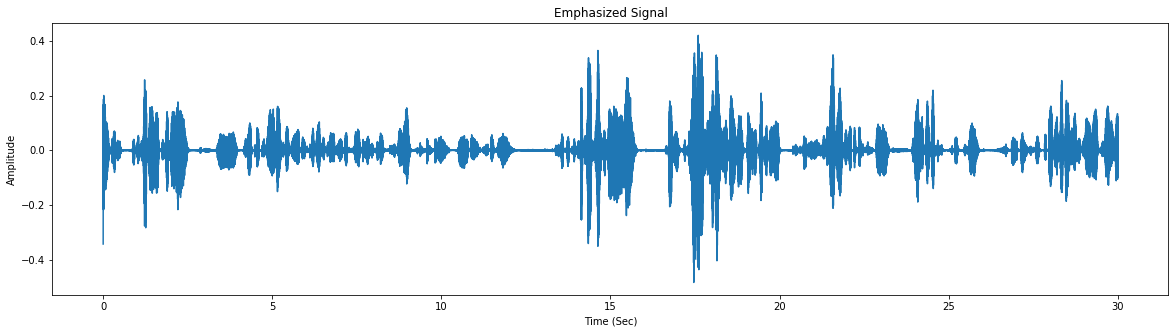

In [0]:
#증폭전 신호
Time=np.linspace(0, len(signal)/sample_rate, num=len(signal))
plt.figure(figsize=(20,5))
plt.plot(Time,signal[:])
plt.title('Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

#증폭후 신호
pre_emphasis = 0.97
print(signal[1:] - pre_emphasis * signal[:-1])
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

ipd.Audio(emphasized_signal, rate=sample_rate)

* silence 삭제

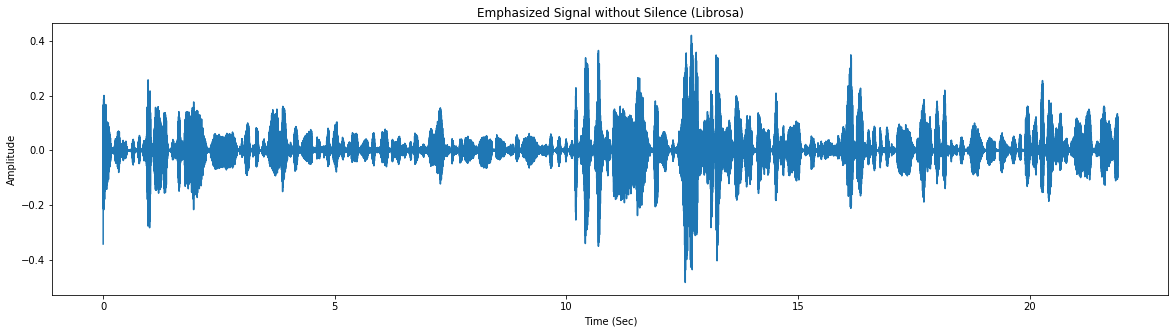

In [0]:
# remove silence
y = librosa.effects.split(emphasized_signal,top_db=30)
l = []
for i in y:
    l.append( emphasized_signal[i[0]:i[1]])
emphasized_signal = np.concatenate(l,axis=0)

Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal without Silence (Librosa)')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

ipd.Audio(emphasized_signal, rate=sample_rate)

In [0]:
print("Librosa Augmentation")
ipd.Audio(emphasized_signal, rate=2*sample_rate)

Librosa Augmentation


* 정규화: 음성크기를 일률적으로 맞추기 위해 

In [0]:
# normalize for energy density
VTH_Multiplier = 0.05
VTH_range=100
energy = [ a**2 for a in emphasized_signal]
Voiced_Threshold = VTH_Multiplier*np.mean(energy)
clean_samples=[0]

for sample_set in range(0,len(emphasized_signal)-VTH_range,VTH_range):
    sample_set_th = np.mean(energy[sample_set:sample_set+VTH_range])
    if sample_set_th>Voiced_Threshold:
        clean_samples.extend(emphasized_signal[sample_set:sample_set+VTH_range])

s = np.array(clean_samples)

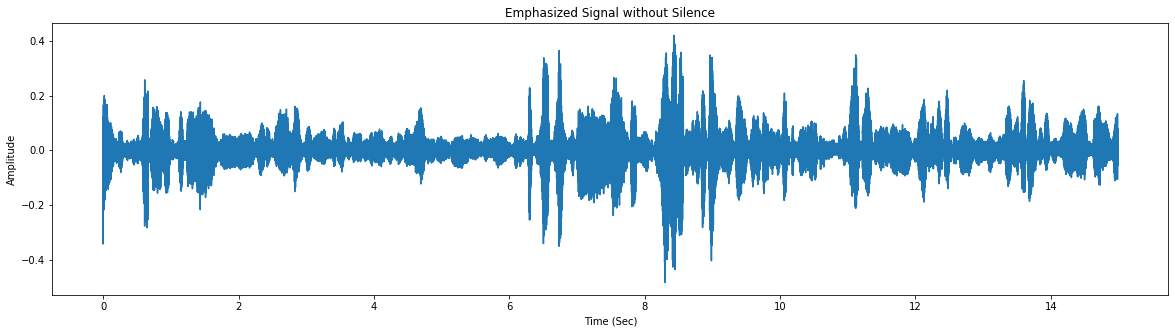

In [0]:
Time=np.linspace(0, len(s)/sample_rate, num=len(s))

plt.figure(figsize=(20,5))
plt.plot(Time,s)
plt.title('Emphasized Signal without Silence')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

ipd.Audio(s, rate=2*sample_rate)

In [0]:
# use normalized signal
emphasized_signal = s

* 음성프레임자르기

In [0]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

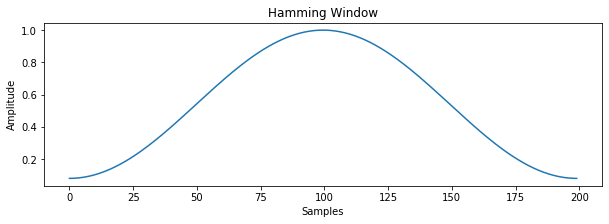

In [0]:
x = numpy.hamming(200)

plt.figure(figsize=(10,3))
plt.plot(x)
plt.title('Hamming Window')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

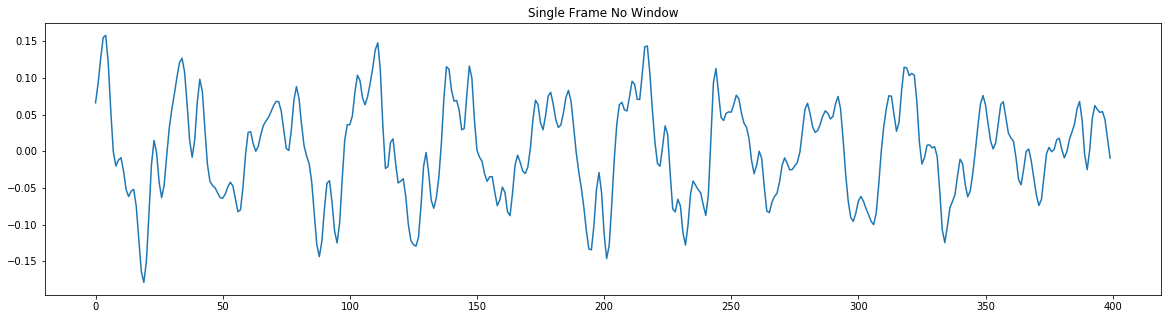

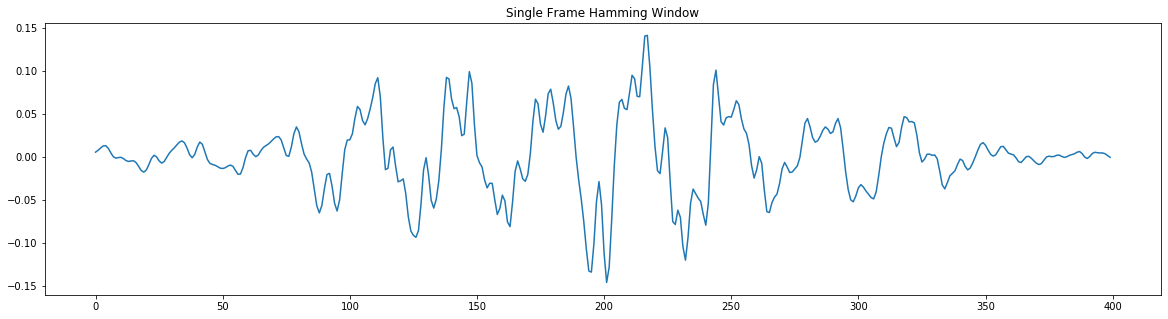

In [0]:
f = frames * numpy.hamming(frame_length)
# frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

x = frames[3]
plt.figure(figsize=(20,5))
plt.plot(x)
plt.title("Single Frame No Window")
plt.show()

x = f[3]
plt.figure(figsize=(20,5))
plt.plot(x)
plt.title("Single Frame Hamming Window")
plt.show()

frames = f

In [0]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT

print(mag_frames)

[[7.32975228e-03 6.76920243e-03 4.42078460e-03 ... 1.21211966e-04
  3.98177700e-04 5.10712760e-04]
 [2.03685456e-03 6.65959967e-03 1.03526381e-02 ... 4.17081570e-04
  1.62491463e-03 2.10259196e-03]
 [5.21444307e-03 3.89455838e-03 7.38120100e-04 ... 1.15448813e-03
  7.48661122e-04 6.69858931e-05]
 ...
 [5.20450624e-03 4.17553409e-03 2.00660089e-03 ... 5.61628244e-04
  7.02833089e-04 7.89238728e-04]
 [1.47858970e-03 1.75007783e-03 1.83498190e-03 ... 8.00433190e-05
  3.23607395e-04 4.18934235e-04]
 [4.28238698e-04 6.80650995e-04 8.50223592e-04 ... 5.63358670e-05
  6.83847553e-05 7.54432379e-05]]


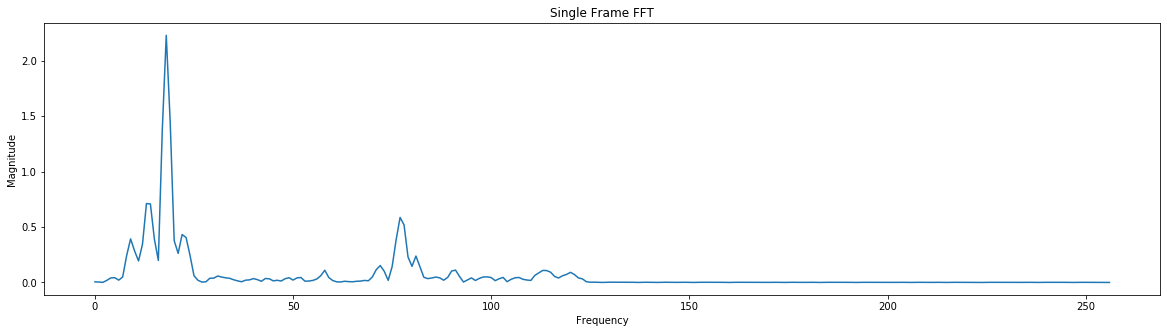

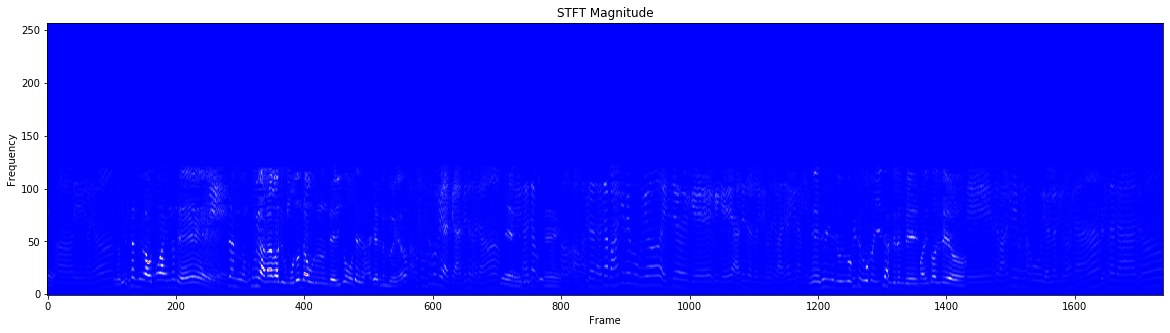

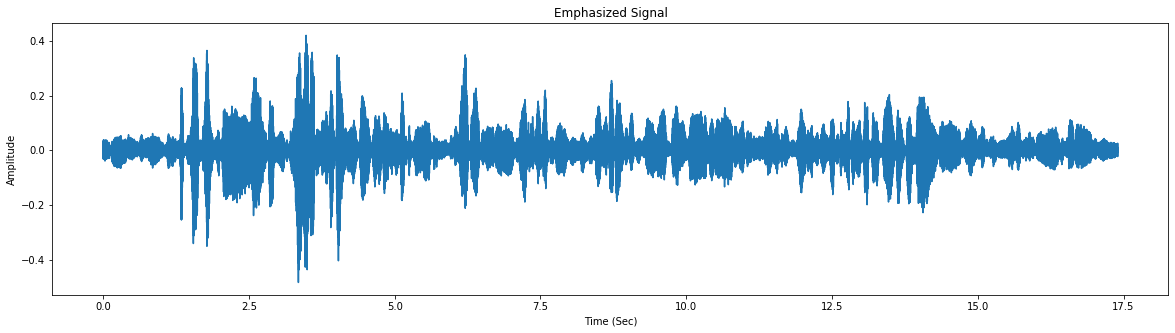

In [0]:
plt.figure(figsize=(20,5))
plt.plot(mag_frames[2])
plt.title("Single Frame FFT")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(mag_frames.T, interpolation='nearest', cmap=cm.bwr, origin='lower', aspect='auto')
plt.title("STFT Magnitude")
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [0]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

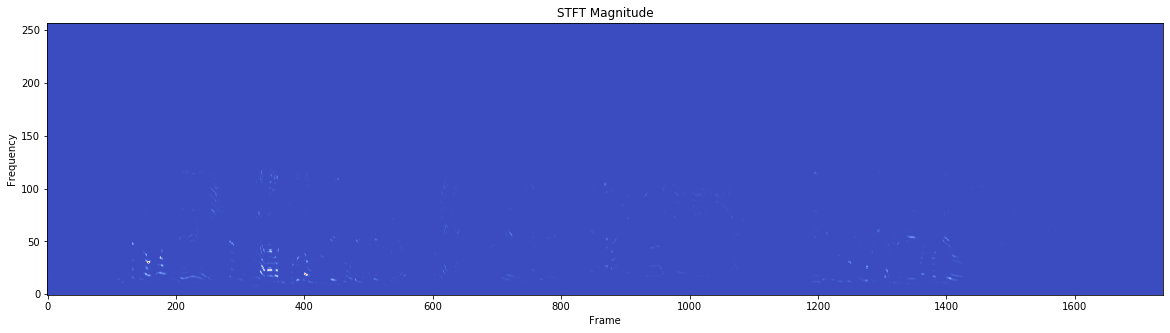

In [0]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(pow_frames.T, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
plt.title("STFT Magnitude")
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.show()

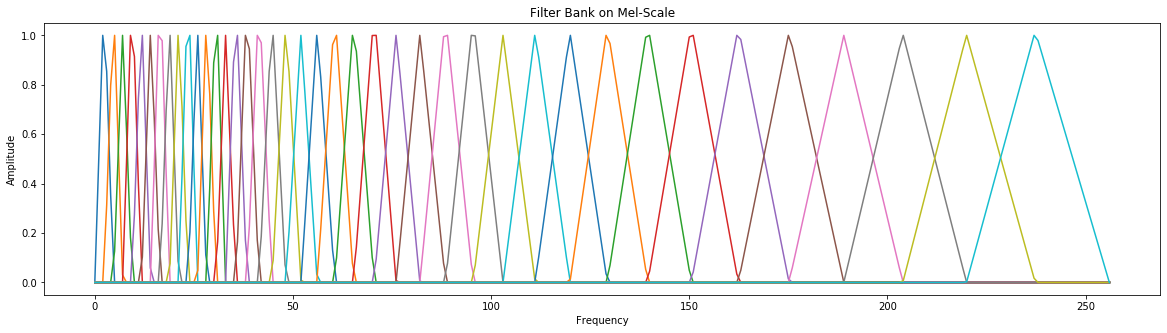

In [0]:
sr = sample_rate
n_fft = 512
n = 40
mels = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n,fmin=0, fmax=sr / 2)
mels /= np.max(mels, axis=-1)[:, None]

plt.figure(figsize=(20,5))
plt.plot(mels.T)
plt.title("Filter Bank on Mel-Scale")
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

In [0]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB


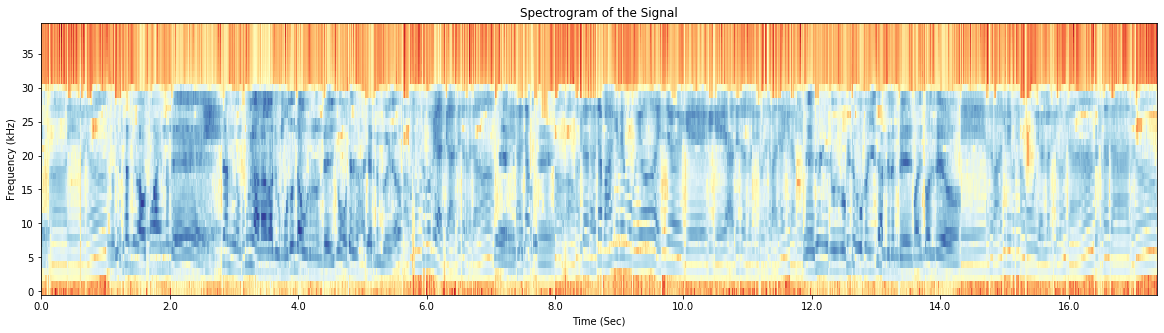

In [0]:
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(filter_banks.T, interpolation='nearest', cmap=cm.RdYlBu, origin='lower', aspect='auto')
plt.title("Spectrogram of the Signal")
plt.xlabel('Time (Sec)')
plt.ylabel('Frequency (kHz)')
a = np.array( ax.get_xticks().tolist() )
a = a / 100.0
ax.set_xticklabels(a)
plt.show()